<a href="https://colab.research.google.com/github/SrkPrasadChangala/pneumoniaDetection/blob/main/PneumoniaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a project to detect pneumonia using X-ray images. We are developing this model with our knowledge of CNNs and transfer learning

In [1]:
#Downloading the dataset from internet
#downloaded will be a tar file
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

--2023-11-17 03:25:42--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.228.249, 54.231.162.57, 54.231.164.97, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.228.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  23.5MB/s    in 41s     

2023-11-17 03:26:23 (28.7 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [2]:
# extracting the dataset from the tarred file to a new folder named xray_dataset
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)
    print(f'Completed extraction and made a new directory xray_dataset')

# Use it like this:
extract_tar_gz('/content/xray_dataset.tar.gz', '/content/xray_dataset')

Completed extraction and made a new directory xray_dataset


**DATA EXPLORATION**

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [4]:
# Lets count the images in each folder

def count_files(directory):

    image_count = 0
    # Iterate through all images in the directory
    for img in os.listdir(directory):
        image_count += 1

    return image_count

normal_test_images_count = count_files('/content/xray_dataset/chest_xray/test/NORMAL')
normal_train_images_count = count_files('/content/xray_dataset/chest_xray/train/NORMAL')
pneumonia_test_images_count = count_files('/content/xray_dataset/chest_xray/test/PNEUMONIA')
pneumonia_train_images_count = count_files('/content/xray_dataset/chest_xray/train/PNEUMONIA')

print(f'Images in train dataset\n \tNormal Images: {normal_train_images_count} \t Pneumonia Images: {pneumonia_train_images_count}\n')
print(f'Images in test dataset\n \tNormal Images: {normal_test_images_count} \t Pneumonia Images: {pneumonia_test_images_count} ')



Images in train dataset
 	Normal Images: 1349 	 Pneumonia Images: 3884

Images in test dataset
 	Normal Images: 234 	 Pneumonia Images: 390 


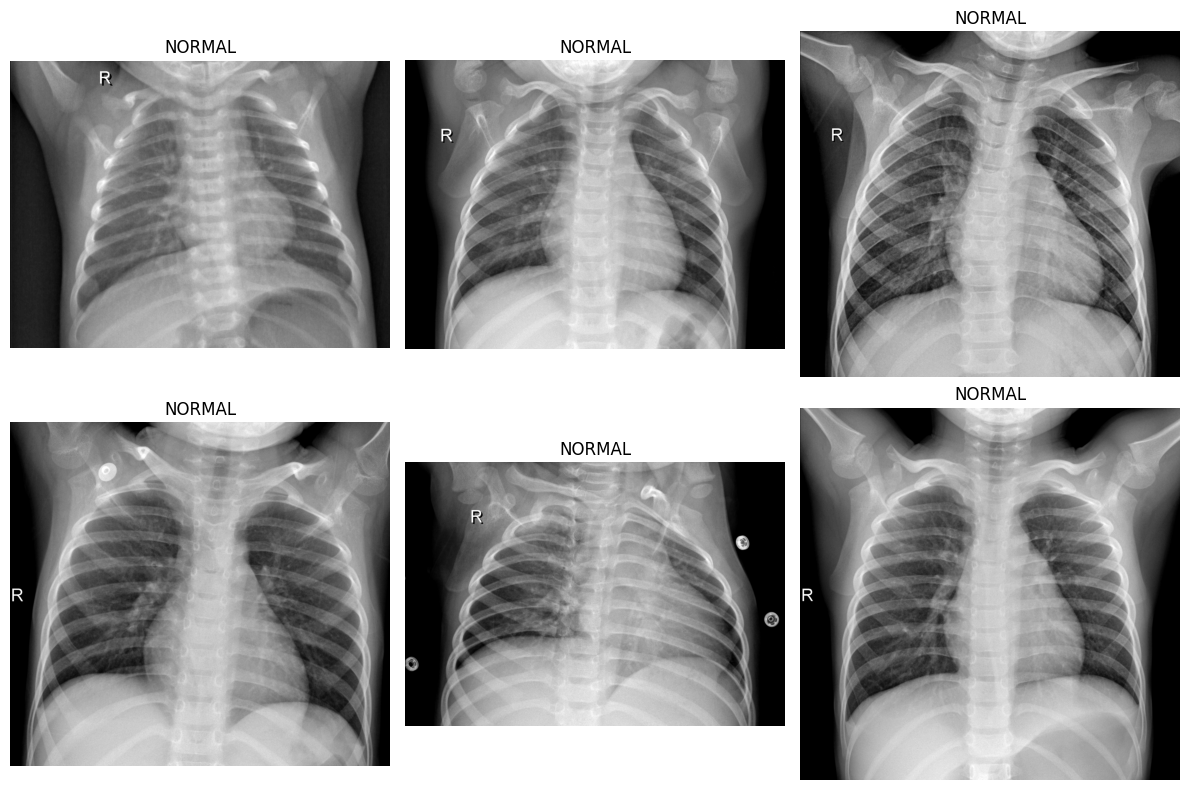

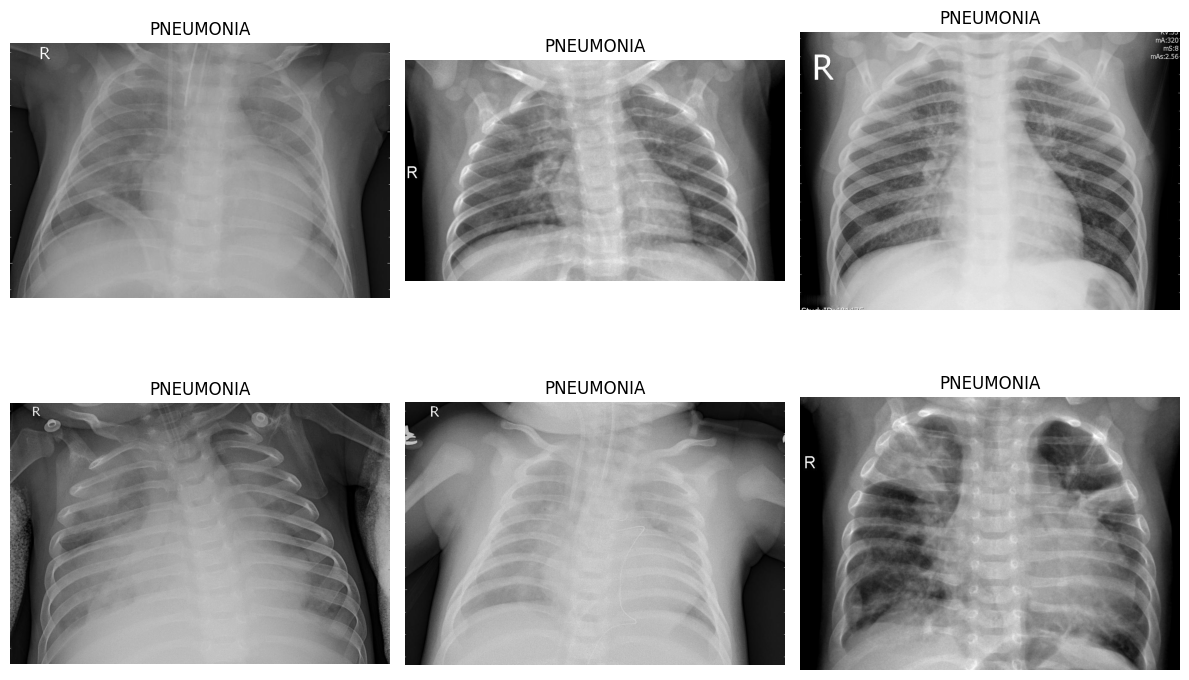

In [5]:
# Directory paths
train_dir_normal = '/content/xray_dataset/chest_xray/train/NORMAL'
train_dir_pneumonia = '/content/xray_dataset/chest_xray/train/PNEUMONIA'

# Function to plot images
def plot_images(class_directory, title, num_images=6):
    plt.figure(figsize=(12, 8))

    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        chosen_image = random.choice(os.listdir(class_directory))
        img_path = os.path.join(class_directory, chosen_image)
        img = mpimg.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plotting images from each class
plot_images(train_dir_normal, 'NORMAL')
plot_images(train_dir_pneumonia, 'PNEUMONIA')

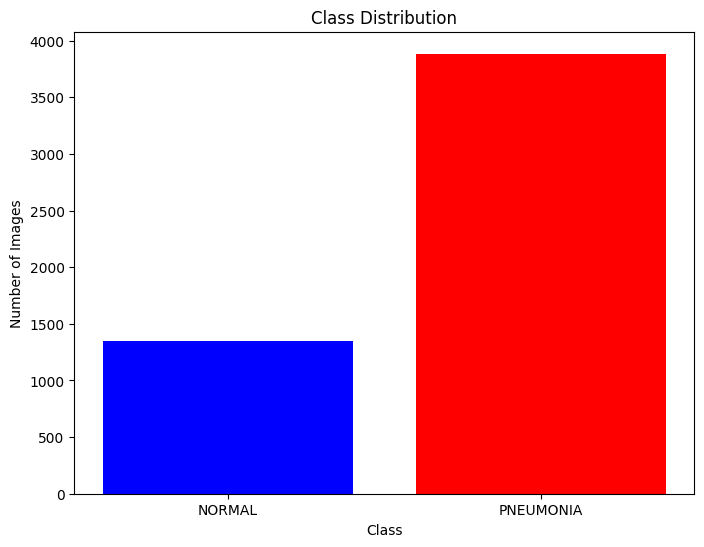

In [6]:
# Checking the class distribution
classes = ['NORMAL', 'PNEUMONIA']
counts = [normal_train_images_count, pneumonia_train_images_count]

plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color=['blue', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


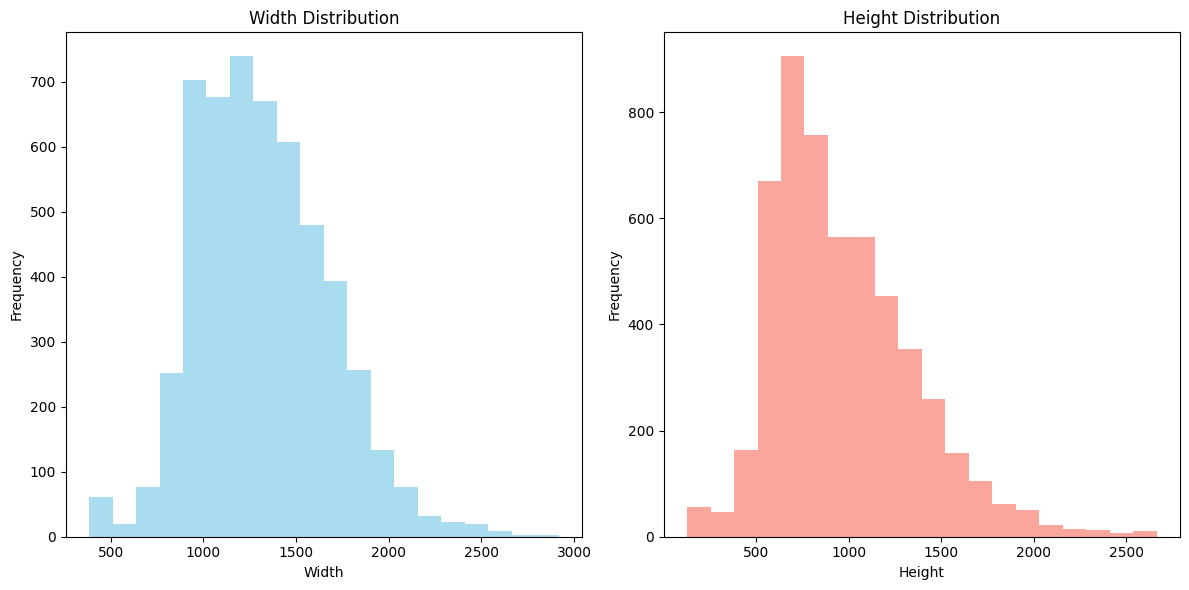

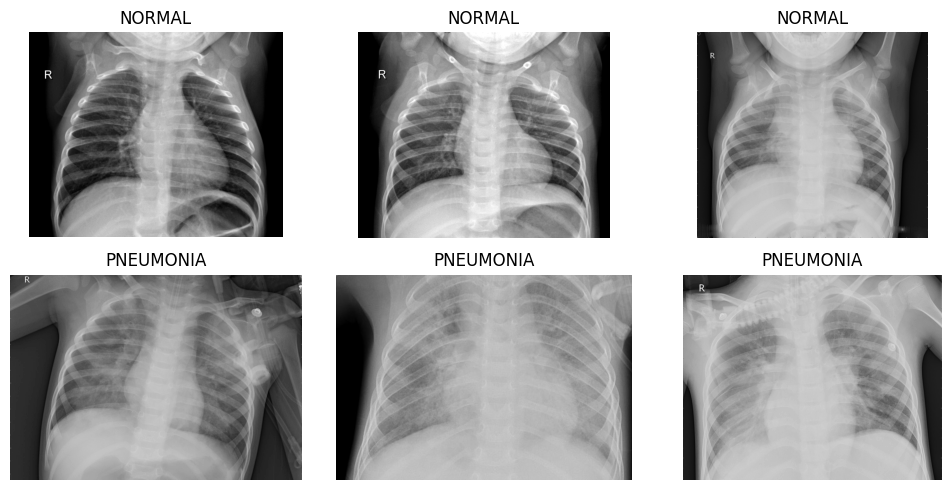

In [7]:
import numpy as np
image_extensions = {".jpg", ".jpeg"}
# Function to analyze image sizes
def analyze_image_sizes(class_directory):
    widths, heights = [], []
    for img_name in os.listdir(class_directory):
        if os.path.splitext(img_name)[1].lower() in image_extensions:
          img_path = os.path.join(class_directory, img_name)
        img = mpimg.imread(img_path)
        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)
    return widths, heights

# Function to plot sample images with labels
def plot_sample_images(class_directories, titles, num_images=3):
    plt.figure(figsize=(10, 5))
    for i, (directory, title) in enumerate(zip(class_directories, titles)):
        for j in range(num_images):
            plt.subplot(2, num_images, i * num_images + j + 1)
            chosen_image = random.choice(os.listdir(directory))
            img_path = os.path.join(directory, chosen_image)
            img = mpimg.imread(img_path)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Analyzing image sizes
widths_normal, heights_normal = analyze_image_sizes(train_dir_normal)
widths_pneumonia, heights_pneumonia = analyze_image_sizes(train_dir_pneumonia)

# Plotting image size distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(widths_normal + widths_pneumonia, bins=20, color='skyblue', alpha=0.7, label='Widths')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights_normal + heights_pneumonia, bins=20, color='salmon', alpha=0.7, label='Heights')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plotting sample images with labels
plot_sample_images([train_dir_normal, train_dir_pneumonia], ['NORMAL', 'PNEUMONIA'])


The histograms indicate that image widths and heights in our dataset are normally distributed, peaking around 1250 and 1000 pixels respectively, with few images exceeding 2500 pixels in either dimension. This suggests that standardizing image sizes to a common dimension like 256x256 pixels for model input might be appropriate, balancing detail retention with computational efficiency.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir = '/content/xray_dataset/chest_xray/train'
test_dir = '/content/xray_dataset/chest_xray/test'

# Parameters
batch_size = 64
image_size = (256, 256)
validation_split = 0.2

# Image Data Generator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split)  # Set validation split

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training')  # Set as training data

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')  # Set as validation data

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Instantiating the model
cnn_model = Sequential(name='cnn_model')

# Adding the convolutional layer
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=image_size + (3,)))

# Adding the max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding the flatten layer
cnn_model.add(Flatten())

# Adding a fully-connected layer
cnn_model.add(Dense(units=128, activation='relu'))

# Adding the output layer
# Use 'sigmoid' activation for binary classification
cnn_model.add(Dense(units=1, activation='sigmoid'))

# Display the model's summary
cnn_model.summary()

# Instantiating the optimizer with a chosen learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compiling the model
cnn_model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Fitting the model on the training set and evaluating it on the validation set
history = cnn_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)


Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 128)               66064512  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66065537 (252.02 MB)
Trainable params: 66065537 (252.02 MB)
Non-trainable params: 0 (0.00 Byte)
_____________